## Import

In [5]:
# Standard Python modules
import os, sys
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
import wrf
from dask.distributed import Client

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
from timeseries import select_months, select_months_ds, combine_ar_ds_df
from statistical_tests import xr_zscore_diff_mean

In [6]:
# Set up paths
path_to_data = '/scratch1/08540/dlnash/data/wrf_6km/'     # project data on Frontera -- read only SCRATCH directory
path_to_data = '/work2/08540/dlnash/frontera/data/wrf_preprocessed_data/wrf_6km/' # WORK directory
# path_to_data = '/home/nash/DATA/data/wrf_hasia/'          # project data on Great -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [7]:
start_date = '1979-12-01'
end_date = '2015-02-28'
mon_s = 12
mon_e = 2

In [8]:
# subregion info for ar type precip anomalies
ext1 = [69, 74, 37, 40] # Northwestern precip anomalies
ext2 = [71, 79, 32, 37] # Western precip anomalies
ext3 = [90, 99, 24, 30] # Eastern precip anomalies
ext4 = [78, 88, 26, 30] # Central Himalaya region
domains = [ext1, ext2, ext3, ext4]
region_name = ['NW', 'W', 'E', 'C']

# domain extent info 
# [xmin, ymin]
sr_xy = []
sr_width = []
sr_height = []

for i, d in enumerate(domains):
    sr_xy.append([d[0], d[2]])
    sr_width.append((d[1] - d[0]))
    sr_height.append((d[3]- d[2]))

print(sr_xy)
print(sr_width)
print(sr_height)

[[69, 37], [71, 32], [90, 24], [78, 26]]
[5, 8, 9, 10]
[3, 5, 6, 4]


In [9]:
filepath = path_to_out + 'DJF_ivt_ar_types_freezing_level_max_prec.csv'
df = pd.read_csv(filepath)
df = df.drop(columns=['Unnamed: 0'])

df

,date,trackID,ar_cat,start_date,end_date,duration,ivty,ivtx,ivt,hlat,...,W_low,W_high,E_low,E_high,C_low,C_high,NW_freeze,W_freeze,E_freeze,C_freeze
0,1979-12-02,2861.0,1,1979-12-02 00:00:00,1979-12-02 18:00:00,18.0,84.715817,156.934744,178.340359,54.000000,...,-171.727932,410.474576,-556.359117,243.805053,NaN,736.425923,1,1,-1,1
1,1979-12-09,2871.0,1,1979-12-09 06:00:00,1979-12-09 18:00:00,12.0,140.456836,255.515681,291.575695,58.855263,...,NaN,570.413285,-638.594000,186.723207,NaN,509.944025,1,1,-1,1
2,1979-12-16,2975.0,1,1979-12-16 12:00:00,1979-12-17 00:00:00,12.0,123.568145,129.182257,178.765606,40.000000,...,-232.334706,151.812409,-659.495027,NaN,-844.268959,NaN,1,1,-1,-1
3,1979-12-21,2988.0,1,1979-12-21 00:00:00,1979-12-22 12:00:00,36.0,118.158087,138.478370,182.037338,33.600000,...,-308.019970,NaN,-964.369488,NaN,-604.454451,NaN,-1,-1,-1,-1
4,1979-12-24,3026.0,1,1979-12-24 06:00:00,1979-12-24 12:00:00,6.0,95.302288,105.452260,142.136221,28.500000,...,NaN,NaN,-120.289555,582.865167,-120.643786,568.642049,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,2015-01-03,114217.0,3,2015-01-03 18:00:00,2015-01-04 00:00:00,6.0,90.024622,127.335315,155.944589,28.500000,...,-266.148849,NaN,-153.740778,740.600011,-514.576338,NaN,-1,-1,1,-1
968,2015-01-21,114363.0,3,2015-01-21 06:00:00,2015-01-22 06:00:00,24.0,136.457574,88.757268,162.783667,32.100000,...,-535.461933,NaN,-140.994532,221.152453,-486.170753,NaN,-1,-1,1,-1
969,2015-01-29,114402.0,3,2015-01-29 12:00:00,2015-01-30 18:00:00,30.0,67.037156,163.407269,176.623656,32.571429,...,-658.230455,NaN,-149.184701,NaN,-686.177485,NaN,-1,-1,-1,-1
970,2015-02-24,114602.0,3,2015-02-24 00:00:00,2015-02-27 06:00:00,78.0,125.874596,149.295575,195.278219,36.465517,...,-245.862589,529.789541,-78.986381,494.138825,NaN,773.009729,1,1,1,1


## WRF 6.7km IVT, geopotential, and precipitation

In [10]:
%%time
start_yr = 1979
end_yr = 2015

domains = ['d02']
varname_lst = ['sr']

# get list of dates that ar is present
ar_dates = pd.to_datetime(df['date']).values

## loop through each ds
ds_lst = []
for i, (dom, varname) in enumerate(zip(domains, varname_lst)):
    filename_pattern = path_to_data + '{0}/{1}/daily/out.wrf6km.{1}.daily_*.nc'.format(dom, varname)
    ds = xr.open_mfdataset(filename_pattern)
    
    # subset freezing level to just ar days
    ds = ds.sel(time = ar_dates)
    
    # Combine AR Cat and freeze data w/ WRF data
    colnames = ['ar_cat', 'NW_freeze', 'W_freeze', 'E_freeze', 'C_freeze']
    for i, col in enumerate(colnames):
        ds[col] = ('time', df[col])
        ds = ds.set_coords(col)
        
    if varname == 'prec':
        ## calculate liquid water (rain = total prec - snow)
        ds = ds.assign(rain=lambda ds: (ds['prec'] - ds['snow']))
    
    ds_lst.append(ds)
    
ds_lst[0]

CPU times: user 216 ms, sys: 127 ms, total: 343 ms
Wall time: 809 ms


,Array,Chunk
Bytes,542.24 MB,10.60 MB
Shape,"(972, 312, 447)","(19, 312, 447)"
Count,222 Tasks,111 Chunks
Type,float32,numpy.ndarray


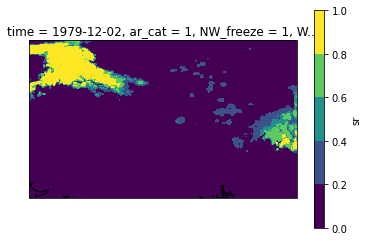

In [11]:
## test plot 1 time step of daily data
ax = plt.axes(projection=ccrs.PlateCarree())

ds_lst[0].sr.isel(time=0).plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

## Compute Composites

In [12]:
%%time
# we want a low freeze plot and a high freeze plot
# each plot is 3 columns (AR Type) by 4 rows (area of freeze cond)
# e.g. composite during Type 1 ARs during low freeze in NW


artype_lst = [1, 2, 3]*12
freeze_lst = ['NW_freeze']*3 + ['W_freeze']*3 + ['E_freeze']*3 + ['C_freeze']*3

comp_low = []
comp_high = []

for i, ds in enumerate(ds_lst):
    for j, (ar_type, freeze) in enumerate(zip(artype_lst, freeze_lst)):
        print(ar_type, freeze)
        idx = (ds[freeze] == -1) & (ds['ar_cat'] == ar_type)
        data = ds.sel(time=idx)
        tmp = data.mean('time').compute()
        comp_low.append(tmp)
        
        idx = (ds[freeze] == 1) & (ds['ar_cat'] == ar_type)
        data = ds.sel(time=idx)
        tmp = data.mean('time').compute()
        comp_high.append(tmp)
        

1 NW_freeze
2 NW_freeze
3 NW_freeze
1 W_freeze
2 W_freeze
3 W_freeze
1 E_freeze
2 E_freeze
3 E_freeze
1 C_freeze
2 C_freeze
3 C_freeze
CPU times: user 4.51 s, sys: 54.6 s, total: 59.1 s
Wall time: 54.8 s


In [13]:
# get terrain height from one wrf file
wrf_filename = "/work2/08540/dlnash/frontera/data/wrf_norris/20211113_case/wrfout_d01_2010-02-04_03:00:00"
# wrf_filename = "/home/hasia/2009/wrfout_d01_2010-02-04_03:00:00"
wrfin = nc.Dataset(wrf_filename)
ter = wrf.getvar(wrfin, 'ter', timeidx=0) # get terrain height

## Plot Composites

In [14]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# plot extents
ext1 = [61, 113, 17, 56] # outer domain 6.7 km WRF
ext2 = [69, 99, 23, 40] # inner domain 6.7 km WRF



# Set tick/grid locations
lonmin, lonmax, latmin, latmax = ext1
dx = np.arange(lonmin,lonmax+10,10)
dy = np.arange(latmin,latmax+10,10)

# hack for tick labels
share_right = [False, False, True]*4
share_bottom = [False]*9 + [True]*3


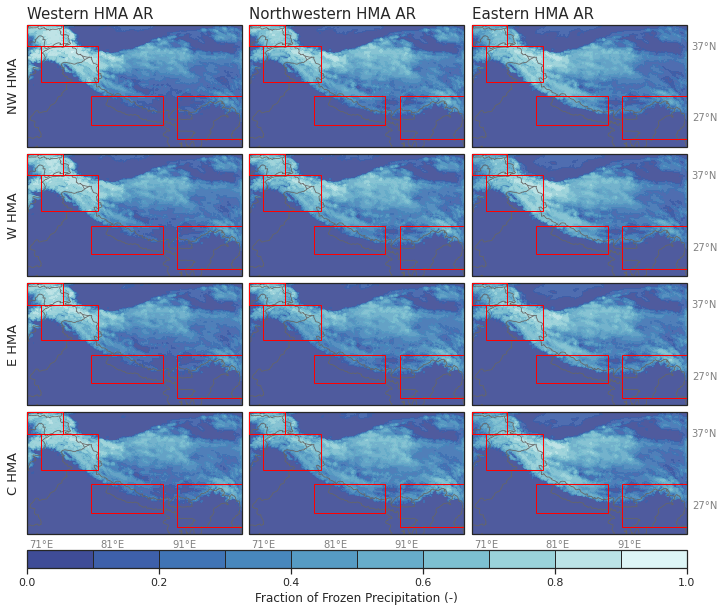

In [15]:
plt_lbl = ['Western HMA AR', 'Northwestern HMA AR', 'Eastern HMA AR'] + ['']*9
row_lbl = ['NW HMA'] + ['']*2 + ['W HMA'] + ['']*2 + ['E HMA'] + ['']*2 + ['C HMA'] + ['']*2

filepath = path_to_figs + 'low_freezing_composite_prec.png'
nrows = 4
ncols = 3

# Create figure
fig = plt.figure(figsize=(15, 10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.1,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.12, cbar_size='5%',label_mode='',
                direction='row')

for k, ax in enumerate(axgr):
    # data = comp_low[24+k] # precip data is item 24:
    data = comp_low[k] # precip data is item 24:

    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=ext2, xticks=dx, yticks=dy,
                      left_lats=False, right_lats=share_right[k], bottom_lons=share_bottom[k])
    
    # Contour Filled
    # snow ratio
    ratio = data.sr.values
    # print(np.nanmin(ratio[ratio != -np.inf]), np.nanmax(ratio[ratio != np.inf]))
    cflevs = np.arange(0, 1.1, 0.1)
    newcmap = cmocean.tools.crop_by_percent(cmo.ice, 30, which='min', N=None)
    cf = ax.contourf(lons, lats, ratio, transform=datacrs,
                     levels=cflevs, cmap=newcmap, alpha=0.9, extend='neither') 
    
    
    # subtitles
    ax.set_title(plt_lbl[k], loc='left',fontsize=15)
    
    # Row labels
    ax.text(-0.03, 0.5, row_lbl[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)
    
    # add subregions
    add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                        height=sr_height, ecolor='red', datacrs=datacrs)
    
    
    
# Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
    cb.set_label('Fraction of Frozen Precipitation (-)')
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


In [16]:
%%time

# Compare conditions (e.g. Type 1 ARs during high freezing vs. neutral conditions) 
artype_lst = [1, 2, 3]*12
freeze_lst = ['NW_freeze']*3 + ['W_freeze']*3 + ['E_freeze']*3 + ['C_freeze']*3

com_diff = []
com_pval = []

for i, ds in enumerate(ds_lst):
    for j, (ar_type, freeze) in enumerate(zip(artype_lst, freeze_lst)):
        print(ar_type, freeze)
        idx = (ds[freeze] == -1) & (ds['ar_cat'] == ar_type)
        data1 = ds.sel(time=idx)
        
        idx = (ds[freeze] == 1) & (ds['ar_cat'] == ar_type)
        data2 = ds.sel(time=idx)

        diff, pval = xr_zscore_diff_mean(data1, data2)

        com_diff.append(diff.compute())
        com_pval.append(pval.compute())
        

1 NW_freeze


/work2/08540/dlnash/frontera/miniconda3/envs/hasia3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


2 NW_freeze


/work2/08540/dlnash/frontera/miniconda3/envs/hasia3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


3 NW_freeze


/work2/08540/dlnash/frontera/miniconda3/envs/hasia3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


1 W_freeze


/work2/08540/dlnash/frontera/miniconda3/envs/hasia3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


2 W_freeze


/work2/08540/dlnash/frontera/miniconda3/envs/hasia3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


3 W_freeze


/work2/08540/dlnash/frontera/miniconda3/envs/hasia3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


1 E_freeze


/work2/08540/dlnash/frontera/miniconda3/envs/hasia3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


2 E_freeze


/work2/08540/dlnash/frontera/miniconda3/envs/hasia3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


3 E_freeze


/work2/08540/dlnash/frontera/miniconda3/envs/hasia3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


1 C_freeze


/work2/08540/dlnash/frontera/miniconda3/envs/hasia3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


2 C_freeze


/work2/08540/dlnash/frontera/miniconda3/envs/hasia3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


3 C_freeze


/work2/08540/dlnash/frontera/miniconda3/envs/hasia3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 17.2 s, sys: 1min 1s, total: 1min 19s
Wall time: 1min 1s


### Plot Difference Composites

In [17]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# plot extents
ext1 = [61, 113, 17, 56] # outer domain 6.7 km WRF
ext2 = [69, 99, 23, 40] # inner domain 6.7 km WRF

# Set tick/grid locations
lonmin, lonmax, latmin, latmax = ext1
dx = np.arange(lonmin,lonmax+10,10)
dy = np.arange(latmin,latmax+5,5)

# hack for tick labels
share_right = [False, False, True]*4
share_bottom = [False]*9 + [True]*3


-0.17802832 0.42030084
-0.103600115 0.43919525
-0.19235557 0.47328597
-0.19591454 0.3786644
-0.09265198 0.45210952
-0.12905866 0.51902306
-0.20364788 0.46570027
-0.16852844 0.46358842
-0.13393243 0.5356
-0.14368731 0.49401107
-0.16071558 0.45698377
-0.15914345 0.4983121


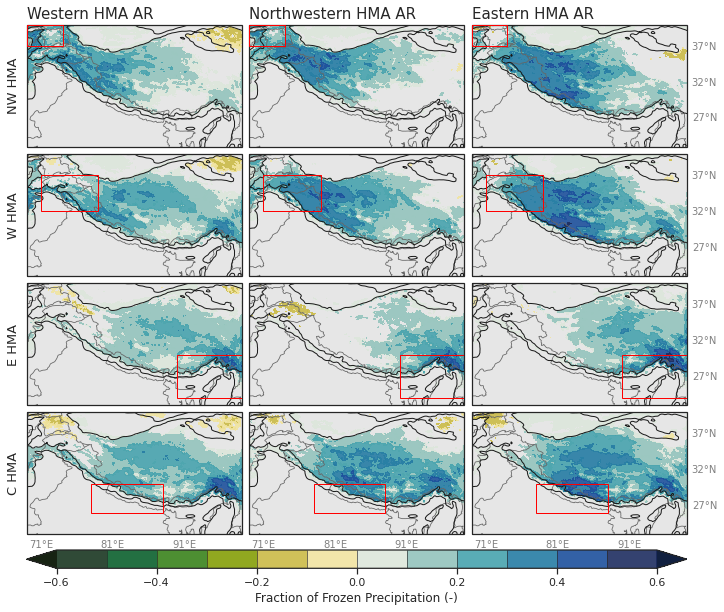

In [19]:
plt_lbl = ['Western HMA AR', 'Northwestern HMA AR', 'Eastern HMA AR'] + ['']*9
row_lbl = ['NW HMA'] + ['']*2 + ['W HMA'] + ['']*2 + ['E HMA'] + ['']*2 + ['C HMA'] + ['']*2
sr_idx = [0]*3 + [1]*3 + [2]*3 + [3]*3

filepath = path_to_figs + 'freezing_sr_diff_composite.png'
nrows = 4
ncols = 3
sig_level = 0.05 # significance level for testing

# Create figure
fig = plt.figure(figsize=(15, 10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.1,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.12, cbar_size='5%',label_mode='',
                direction='row')

for k, ax in enumerate(axgr):
    data = com_diff[k]
    pval = com_pval[k]

    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=ext2, xticks=dx, yticks=dy,
                      left_lats=False, right_lats=share_right[k], bottom_lons=share_bottom[k])
    
    # Contour Filled
    ratio = data.sr.values
    print(np.nanmin(ratio), np.nanmax(ratio))
    ratio_mask = data.sr.where((pval.sr <= sig_level)).values
    # print(np.nanmin(ratio[ratio != -np.inf]), np.nanmax(ratio[ratio != np.inf]))
    cflevs = np.arange(-0.6, 0.7, 0.1)
    # newcmap = cmocean.tools.crop_by_percent(cmo.ice, 30, which='min', N=None)
    cf = ax.contourf(lons, lats, ratio_mask, transform=datacrs,
                     levels=cflevs, cmap=cmo.delta_r, alpha=0.9, extend='both')
    
    # Contour Lines (terrain)
    clevs=np.array([1000, 3000])
    cs = ax.contour(ter.XLONG, ter.XLAT, ter.values, clevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)
    
    
    # subtitles
    ax.set_title(plt_lbl[k], loc='left',fontsize=15)
    
    # Row labels
    ax.text(-0.03, 0.5, row_lbl[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)
    
    # add subregions
    m = sr_idx[k]
    add_subregion_boxes(ax=ax, subregion_xy=[sr_xy[m]], width=[sr_width[m]], 
                        height=[sr_height[m]], ecolor='red', datacrs=datacrs)
    
    
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('Fraction of Frozen Precipitation (-)')
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


-0.19591454 0.3786644
-0.103600115 0.43919525
-0.13393243 0.5356


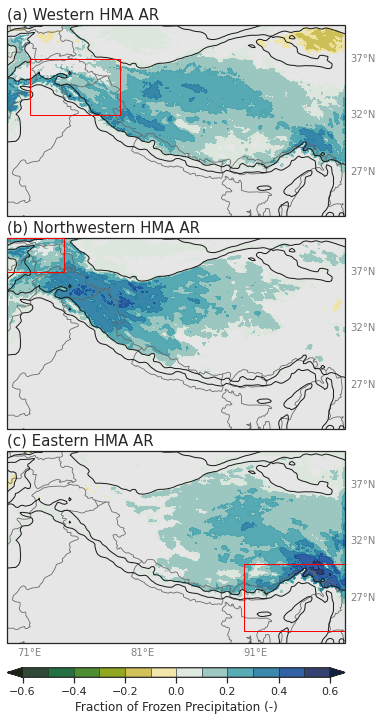

In [20]:
plt_lbl = ['(a) Western HMA AR', '(b) Northwestern HMA AR', '(c) Eastern HMA AR']
ar_idx = [3, 1, 8]
sr_idx = [1, 0, 2]

share_bottom=[False, False, True]

filepath = path_to_figs + 'freezing_sr_diff_composite_portrait.png'
nrows = 3
ncols = 1
sig_level = 0.05 # significance level for testing

# Create figure
fig = plt.figure(figsize=(10, 12))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.3,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='5%',label_mode='',
                direction='row')

for k, ax in enumerate(axgr):
    i = ar_idx[k]
    data = com_diff[i]
    pval = com_pval[i]

    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=ext2, xticks=dx, yticks=dy,
                      left_lats=False, right_lats=True, bottom_lons=share_bottom[k])
    
    # Contour Filled
    ratio = data.sr.values
    print(np.nanmin(ratio), np.nanmax(ratio))
    ratio_mask = data.sr.where((pval.sr <= sig_level)).values
    # print(np.nanmin(ratio[ratio != -np.inf]), np.nanmax(ratio[ratio != np.inf]))
    cflevs = np.arange(-0.6, 0.7, 0.1)
    # newcmap = cmocean.tools.crop_by_percent(cmo.ice, 30, which='min', N=None)
    cf = ax.contourf(lons, lats, ratio_mask, transform=datacrs,
                     levels=cflevs, cmap=cmo.delta_r, alpha=0.9, extend='both')
    
    # Contour Lines (terrain)
    clevs=np.array([1000, 3000])
    cs = ax.contour(ter.XLONG, ter.XLAT, ter.values, clevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)
    
    
    # subtitles
    ax.set_title(plt_lbl[k], loc='left',fontsize=15)
    
    # add subregions
    m = sr_idx[k]
    add_subregion_boxes(ax=ax, subregion_xy=[sr_xy[m]], width=[sr_width[m]], 
                        height=[sr_height[m]], ecolor='red', datacrs=datacrs)
    
    
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('Fraction of Frozen Precipitation (-)')
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


-0.19591454 0.3786644
-0.103600115 0.43919525
-0.13393243 0.5356


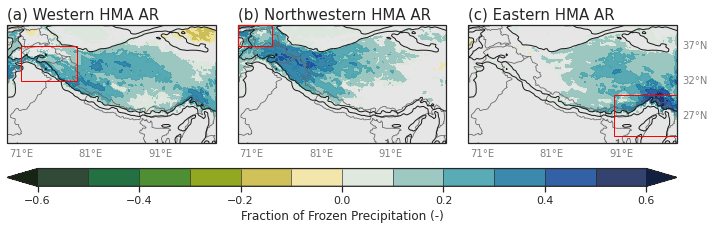

In [21]:
plt_lbl = ['(a) Western HMA AR', '(b) Northwestern HMA AR', '(c) Eastern HMA AR']
ar_idx = [3, 1, 8]
sr_idx = [1, 0, 2]

share_right=[False, False, True]

filepath = path_to_figs + 'freezing_sr_diff_composite_landscape.png'
nrows = 1
ncols = 3
sig_level = 0.05 # significance level for testing

# Create figure
fig = plt.figure(figsize=(12, 10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.3,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='5%',label_mode='',
                direction='row')

for k, ax in enumerate(axgr):
    i = ar_idx[k]
    data = com_diff[i]
    pval = com_pval[i]

    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=ext2, xticks=dx, yticks=dy,
                      left_lats=False, right_lats=share_right[k], bottom_lons=True)
    
    # Contour Filled
    ratio = data.sr.values
    print(np.nanmin(ratio), np.nanmax(ratio))
    ratio_mask = data.sr.where((pval.sr <= sig_level)).values
    # print(np.nanmin(ratio[ratio != -np.inf]), np.nanmax(ratio[ratio != np.inf]))
    cflevs = np.arange(-0.6, 0.7, 0.1)
    # newcmap = cmocean.tools.crop_by_percent(cmo.ice, 30, which='min', N=None)
    cf = ax.contourf(lons, lats, ratio_mask, transform=datacrs,
                     levels=cflevs, cmap=cmo.delta_r, alpha=0.9, extend='both')
    
    # Contour Lines (terrain)
    clevs=np.array([1000, 3000])
    cs = ax.contour(ter.XLONG, ter.XLAT, ter.values, clevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)
    
    
    # subtitles
    ax.set_title(plt_lbl[k], loc='left',fontsize=15)
    
    # add subregions
    m = sr_idx[k]
    add_subregion_boxes(ax=ax, subregion_xy=[sr_xy[m]], width=[sr_width[m]], 
                        height=[sr_height[m]], ecolor='red', datacrs=datacrs)
    
    
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('Fraction of Frozen Precipitation (-)')
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()
